In [40]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [41]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
# Load dataset
df = pd.read_csv("zomato_reviews.csv")  # Replace with actual dataset
df = df[['review', 'rating']]  # Select relevant columns
df.head()


,review,rating
0,nice,5
1,"best biryani , so supportive staff of outlet ,...",5
2,delivery boy was very decent and supportive.👌👍,4
3,"worst biryani i have tasted in my life, half o...",1
4,all food is good and tasty . will order again ...,5


In [43]:
import nltk

# Download all required resources
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopword removal
nltk.download('wordnet')  # For lemmatization
nltk.download('omw-1.4')  # Open Multilingual WordNet data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [44]:
def text_processing(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    
    # Simple tokenization by splitting on spaces
    tokens = text.split()
    
    # Remove stopwords (if stopwords are available)
    try:
        from nltk.corpus import stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [t for t in tokens if t not in stop_words]
    except LookupError:
        # If stopwords aren't available, continue without removing them
        pass
    
    # Lemmatization (if WordNet is available)
    try:
        from nltk.stem import WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    except LookupError:
        # If WordNet isn't available, continue without lemmatization
        pass
    
    return ' '.join(tokens)

In [45]:
df['Processed_Review'] = df['review'].astype(str).apply(text_processing)
df.head()

,review,rating,Processed_Review
0,nice,5,nice
1,"best biryani , so supportive staff of outlet ,...",5,best biryani supportive staff outlet personali...
2,delivery boy was very decent and supportive.👌👍,4,delivery boy decent supportive
3,"worst biryani i have tasted in my life, half o...",1,worst biryani tasted life half biryani dustbin
4,all food is good and tasty . will order again ...,5,food good tasty order lot explore bawarchi menu


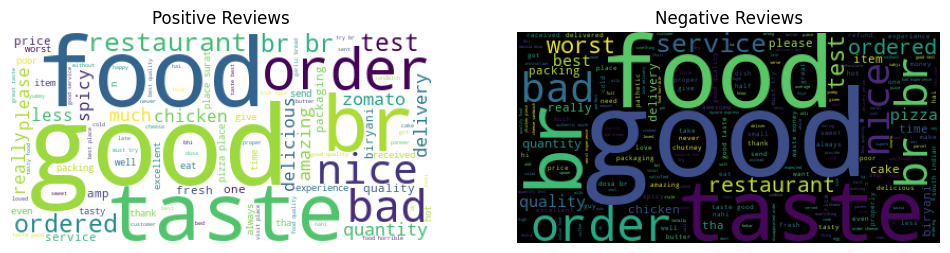

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate positive and negative reviews
positive_reviews = ' '.join(df[df['rating'] >= 4]['Processed_Review'])
negative_reviews = ' '.join(df[df['rating'] <= 2]['Processed_Review'])

# Generate word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(background_color='white').generate(positive_reviews))
plt.title("Positive Reviews")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(background_color='black').generate(negative_reviews))
plt.title("Negative Reviews")
plt.axis("off")

plt.show()


# Rule-Based Sentiment Analysis (using VADER)

In [47]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
df['Sentiment_Score'] = df['Processed_Review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Labeling sentiment
df['Sentiment'] = df['Sentiment_Score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

df[['review', 'Sentiment_Score', 'Sentiment']].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,review,Sentiment_Score,Sentiment
0,nice,0.4215,Positive
1,"best biryani , so supportive staff of outlet ,...",0.7506,Positive
2,delivery boy was very decent and supportive.👌👍,0.2960,Positive
3,"worst biryani i have tasted in my life, half o...",-0.6249,Negative
4,all food is good and tasty . will order again ...,0.4404,Positive


# Sentiment-Analysis using TF-IDF and Logistic Regression

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Convert rating into binary labels (Positive: 4-5, Negative: 1-2)
df['Label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Processed_Review'])
y = df['Label']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5209854014598541
              precision    recall  f1-score   support

           0       0.52      0.58      0.55       548
           1       0.52      0.47      0.49       548

    accuracy                           0.52      1096
   macro avg       0.52      0.52      0.52      1096
weighted avg       0.52      0.52      0.52      1096



# Aspect-Based Sentiment Analysis 

In [49]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['Aspect_Sentiment'] = df['Processed_Review'].apply(get_sentiment)
df[['review', 'Aspect_Sentiment']].head()


,review,Aspect_Sentiment
0,nice,0.600000
1,"best biryani , so supportive staff of outlet ,...",0.616667
2,delivery boy was very decent and supportive.👌👍,0.333333
3,"worst biryani i have tasted in my life, half o...",-0.583333
4,all food is good and tasty . will order again ...,0.700000
